## Diamagnetic Drift
2D simulations of Fliud Drifts

#### About the phenomenon

The Diamagnetic drift or diamagnetic current is a fluid drift in which a current arrises in a magnetized plasma with a given density gradient.

If the density gradient is perpendicular to the mangletic field, inside a given fluid element, there will be more particles undergoing gyroscopic motion (see figure below). Due to this difference in the number of particles in each side of the fluid element, there will be more 
particles moving downwards than upwards giving rise to a fluid drift perpendicular to
both the density gradient and B. However, the guiding centres remain stationary.

This effect can be understood as a fictional drift as there is no single particle drifting from its gyroscopic center, but a net current on a fluid element. 

#### About the simulation
We will be using the 2D version of **ZPIC**. With this particle in cell code we are required to initialize a full plasma instead of a single particle. However, we may still track single particles and eliminate collective effects by decreasing the plasma density.

In [1]:
import sys  
sys.path.insert(0, '../source')

# get ZPIC 2D
import em2d
import numpy as np

# SIMULATION PARAMETERS
#Time step
dt = 0.0055
#Simulation time
tmax = 22.8
#Number of cells
nx  = [192,192]
#Simulation box size
box = [1.5,1.5]

# PLASMA SPECIES PARAMETERS
#Particles per cell
ppc = [4,4]
#density gradient
def custom_nx(x):
    return 1+2*x if (x>0.25 and x<1.25) else 0.0
def custom_ny(x):
    return 1 if (x>0.25 and x<1.25) else  0.0
dens = em2d.Density( type = "custom", custom_x = custom_nx,custom_y=custom_ny )
# Set up a super low density
dens.n=1e-6
#create the species with a thermal velocity distribution to kick of the motion
electrons = em2d.Species( "electrons", -1, ppc,
                           density = dens,ufl=[0,0,0],uth=[0.05,0.05,0])

# INITIALIZE SIMULATION OBJECT
sim = em2d.Simulation( nx, box, dt, species = electrons )


#Set the sorting period to 0 in order to track the particle's trajectories 
#(this must be done after initilializng the simulation object)
electrons.n_sort=0

# EXTERNAL FIELDS
B=[0,0,1]
ext = em2d.ExternalField(B_type = 'uniform', B_0 = B,E_type = 'none')
sim.emf.set_ext_fld( ext )

Here you can check the charge density of the plasma species you've just created

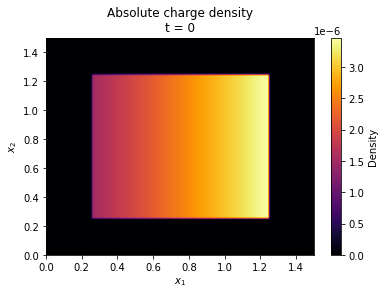

In [2]:
import matplotlib.pyplot as plt
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.imshow(np.abs(electrons.charge()), extent = ( 0,sim.box[0], 0,sim.box[1]),
          aspect = 'auto', cmap = 'inferno' )
plt.colorbar().set_label('Density')
plt.title("Absolute charge density\nt = {:g}".format(sim.t))
plt.show()

**Q:** Given this density distribution, in which direction will the drift be oriented?

***
*anwser*
___

Now running the simulation for a bunch of periods

In [3]:
#objects to store the avg current in the x (=x1) and y (=x2) directions
currnt_x=sim.current.Jx.copy()
currnt_y=sim.current.Jy.copy()

import random
p_idx=random.sample(range(len(electrons.particles)),64)
ele_part_rep=[]

while sim.t < 4*np.pi:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    sim.iter()
    
    currnt_x=currnt_x+sim.current.Jx.copy()
    currnt_y=currnt_y+sim.current.Jy.copy()
    if sim.n%10 ==0:
        ele_part_rep.append(electrons.particles[p_idx].copy())

### Checking the results

Here you can check the resulting time averaged currents.

If evreytihng went as expected there should be a net current in the direction perpendicular to $B$ and $\nabla n$.



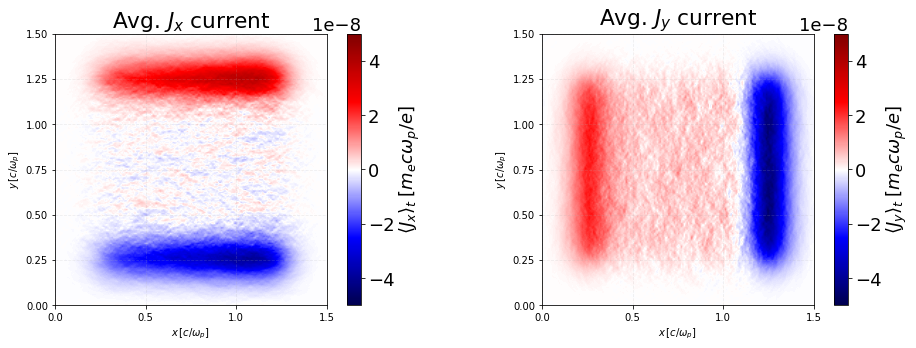

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import random 
#Set up the plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plt.rcParams.update({'font.size': 18})

im=axes[0].imshow(currnt_x/sim.n, interpolation = 'bilinear', origin = 'lower',
          extent = ( 0, sim.box[0], 0, sim.box[1] ),
           vmin=-5e-8,vmax=5e-8,
          aspect = 'auto', cmap = 'seismic' )
cbar=plt.colorbar(im,ax=axes[0])
cbar.set_label(r"$\langle J_x \rangle_t\;[m_ec\omega_p/e]$")
axes[0].set_ylabel("$y\,[c/\omega_p]$")
axes[0].grid(True,ls="--",alpha=0.2)
axes[0].set_xlabel("$x\,[c/\omega_p]$")
axes[0].set_aspect('equal')
axes[0].set_title("Avg. $J_x$ current")

im=axes[1].imshow(currnt_y/sim.n, interpolation = 'bilinear', origin = 'lower',
          extent = ( 0, sim.box[0], 0, sim.box[1] ),
           vmin=-5e-8,vmax=5e-8,
          aspect = 'auto', cmap = 'seismic' )
cbar=plt.colorbar(im)
cbar.set_label(r"$\langle J_y \rangle_t\;[m_ec\omega_p/e]$")
##setup labels, grids, and others
axes[1].grid(True,ls="--",alpha=0.2)
axes[1].set_xlabel("$x\,[c/\omega_p]$")
axes[1].set_aspect('equal')
axes[1].set_ylabel("$y\,[c/\omega_p]$")
axes[1].set_title("Avg. $J_y$ current")
plt.show()

**Q:** Aside from this current there are also accumulations of current near the edges of the plasma, this is also a manifestation of the diamagnetic drift. Explain why.

***
*anwser*
___

It's also useful to compare the results with the theoretical expectations.

The diamagnetic current can be calculated as 

$J_{diag}=KT_e\frac{\mathbf{B}\times\mathbf{\nabla} n}{B^2}$

Where $KTe$ is calculated with a thermal velocity distribution in all 3 directions.

$3KT_e=u_{th,x}^2+u_{th,y}^2+u_{th,z}^2$

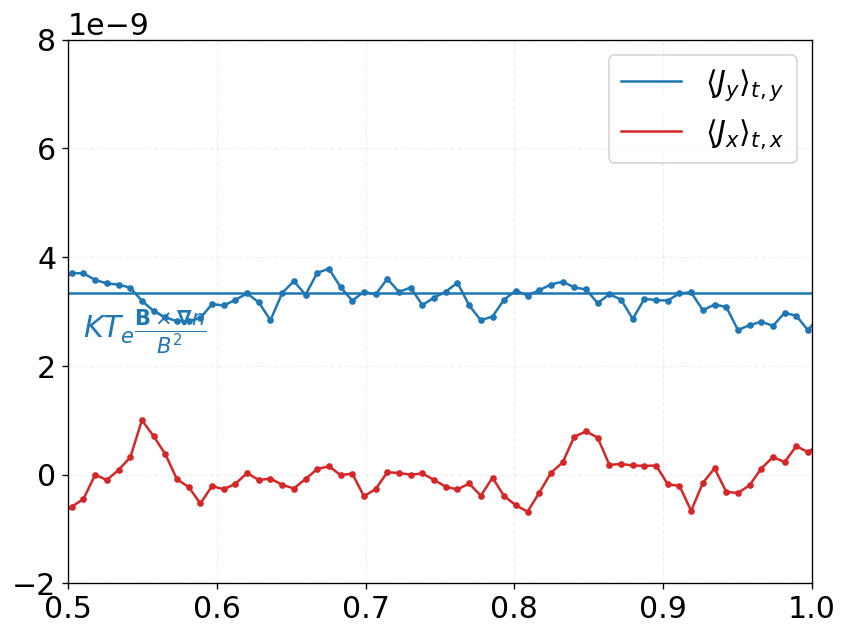

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import random 
#Set up the plot
fig=plt.figure(figsize=(8, 6), dpi=120)
plt.rcParams.update({'font.size': 18})
ax=plt.gca()
ax.grid(True,ls="--",alpha=0.2)


#Y current
ax.plot(np.linspace(0,box[0],nx[0]),np.sum(currnt_y/sim.n,axis=0)/len(currnt_y[0]),label=r"$\langle J_y \rangle_{t,y}$")
ax.plot(np.linspace(0,box[0],nx[0]),np.sum(currnt_y/sim.n,axis=0)/len(currnt_y[0]),'.',c="C0")

#x current
ax.plot(np.linspace(0,box[0],nx[0]),np.sum(currnt_x/sim.n,axis=1)/len(currnt_y[0]),c="C3",label=r"$\langle J_x \rangle_{t,x}$")
ax.plot(np.linspace(0,box[0],nx[0]),np.sum(currnt_x/sim.n,axis=1)/len(currnt_y[0]),'.',c="C3")

#theory
ax.axhline(2e-6*(0.05*0.05+0.05*0.05)/3)


ax.set_xlim(0.5,1.0)
ax.set_ylim(-2e-9,8e-9)
ax.text(0.51,2.5e-9,r"$KT_e\frac{\mathbf{B}\times\mathbf{\nabla} n}{B^2}$",color="C0")

ax.legend()

The last visualization serves the purpose of convincing you that the diamagntic drift current results form the plasma density gradient and not from single particle drifts.

By looking at the tracjectories of some of the plasma's particles we see that they only perform the cyclotron motion.

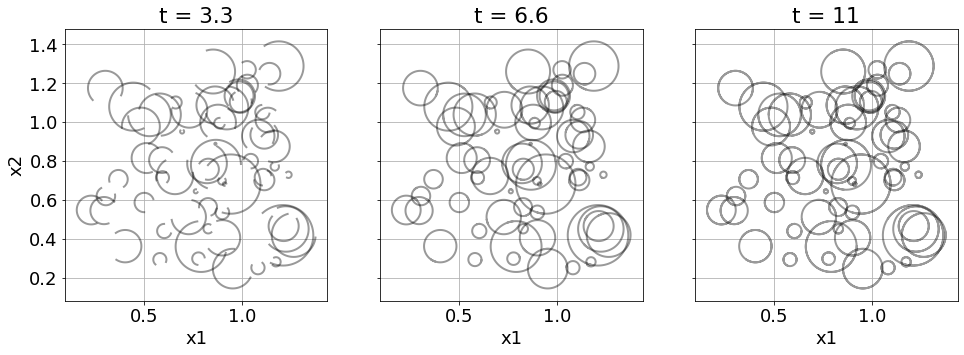

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

a=np.transpose(ele_part_rep)
for particle in a:
    e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in particle]
    e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in particle]
    axes[0].plot(e_posx_t[:80],e_posy_t[:80],c="k",alpha=0.4,lw=2)
    axes[1].plot(e_posx_t[:120],e_posy_t[:120],c="k",alpha=0.4,lw=2)
    axes[2].plot(e_posx_t[:200],e_posy_t[:200],c="k",alpha=0.4,lw=2)


axes[0].set_title("t = {:g}".format(dt*600))

axes[1].set_yticklabels([])
axes[1].set_title("t = {:g}".format(dt*1200))

axes[2].set_yticklabels([])
axes[2].set_title("t = {:g}".format(dt*2000))


for ax in axes:
    ax.set_xlabel("x1")
    ax.set_aspect('equal' ,'datalim')
    ax.grid()
    
axes[0].set_ylabel("x2")
plt.show()